In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random

In [174]:
df = pd.read_csv("dataset.csv")
df.head()

,song_id,keyword_1,keyword_2,keyword_3,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop


## Generating word embeddings for the keywords using BoW

In [219]:
KEYWORD_MAPPING = {}
ALL_KEYWORDS = {}
c = 1

for idx, row in df.iterrows():
    for i in range(1, 4):

        # for ALL_KEYWORDS
        if row[f'keyword_{i}'] not in ALL_KEYWORDS:
            ALL_KEYWORDS[row[f'keyword_{i}']] = c
            c += 1

        # for KEYWORD_MAPPPING
        if row[f'keyword_{i}'] in KEYWORD_MAPPING:
            
            for j in range(1, 4):
                if i != j:
                    if row[f'keyword_{j}'] in KEYWORD_MAPPING[row[f'keyword_{i}']] :
                        KEYWORD_MAPPING[row[f'keyword_{i}']][row[f'keyword_{j}']] += 1
                    else:
                        KEYWORD_MAPPING[row[f'keyword_{i}']][row[f'keyword_{j}']] = 0
                        
        else:
            KEYWORD_MAPPING[row[f'keyword_{i}']] = {}

MOST_OCCURED = 0
for i in KEYWORD_MAPPING:
    for j in KEYWORD_MAPPING[i]:
        if KEYWORD_MAPPING[i][j] > MOST_OCCURED:
            MOST_OCCURED = KEYWORD_MAPPING[i][j]

KEYWORD_MAPPING, ALL_KEYWORDS, MOST_OCCURED

({'guitar': {'energetic': 14,
   'melodic': 10,
   'happy': 11,
   'heavy': 4,
   'nostalgic': 2,
   'twangy': 3,
   'upbeat': 11,
   'mellow': 11,
   'emotional': 0,
   'rhythmic': 3,
   'sad': 10,
   'acoustic': 7,
   'fast': 10,
   'angry': 5,
   'distorted': 3,
   'slow': 5,
   'danceable': 1,
   'calm': 0},
  'happy': {'banjo': 0,
   'acoustic': 1,
   'guitar': 11,
   'heavy': 1,
   'brass': 2,
   'slow': 3,
   'upbeat': 4,
   'synth': 8,
   'fast': 4,
   'melodic': 4,
   'rhythmic': 3,
   'twangy': 0,
   'violin': 2,
   'danceable': 0,
   'piano': 0},
  'distorted': {'guitar': 3,
   'energetic': 0,
   'angry': 0,
   'mellow': 0,
   'sad': 0},
  'brass': {'calm': 1,
   'upbeat': 1,
   'happy': 2,
   'slow': 1,
   'mellow': 1,
   'fast': 3,
   'energetic': 1,
   'melodic': 1,
   'sad': 0},
  'energetic': {'synth': 6,
   'heavy': 1,
   'slow': 4,
   'guitar': 14,
   'melodic': 2,
   'twangy': 0,
   'upbeat': 2,
   'fast': 5,
   'acoustic': 1,
   'distorted': 0,
   'violin': 0,
   'b

In [223]:
def create_embeddings(keyword):

    ans = np.zeros(len(ALL_KEYWORDS) + 1)
    ans[ALL_KEYWORDS[keyword]] = MOST_OCCURED*2
    
    for key in KEYWORD_MAPPING:
        if key != keyword:
            if key in KEYWORD_MAPPING[keyword]:
                ans[ALL_KEYWORDS[key]] = KEYWORD_MAPPING[keyword][key]

    return ans

create_embeddings('slow')

array([ 0.,  5.,  3.,  0.,  1.,  3.,  0.,  0.,  0.,  5.,  0., 28.,  2.,
        0.,  2.,  2.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.])

In [224]:
def give_df_keyword_embeddings(df):
    arr = []
    for idx, row in df.iterrows():
        t = []
        t.append(create_embeddings(row['keyword_1']))
        t.append(create_embeddings(row['keyword_2']))
        t.append(create_embeddings(row['keyword_3']))
        arr.append(t)

    return np.array(arr)

In [225]:
embeddings = give_df_keyword_embeddings(df)
embeddings

array([[[ 0., 28., 11., ...,  5., 10.,  1.],
        [ 0., 11., 28., ...,  0.,  0.,  0.],
        [ 0.,  3.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  2., ...,  0.,  0.,  0.],
        [ 0., 14.,  0., ...,  0.,  0.,  0.],
        [ 0., 10.,  4., ...,  1.,  4.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 11., 28., ...,  0.,  0.,  0.],
        [ 0.,  7.,  0., ...,  0.,  1.,  0.]],

       ...,

       [[ 0., 28., 11., ...,  5., 10.,  1.],
        [ 0., 11., 28., ...,  0.,  0.,  0.],
        [ 0.,  3.,  3., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  8., ...,  5.,  5.,  2.],
        [ 0., 11.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 28.]],

       [[ 0.,  0.,  8., ...,  5.,  5.,  2.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  5.,  3., ...,  0.,  2.,  0.]]])

## Dimensionality Reduction for each keyword matrix

In [226]:
# reducing features to useful features only
class PCA:
    def __init__(self, n):
        self.n = n
        self.mean = None
        self.components = None
        
    def fit(self, vec):
        self.mean = np.mean(vec, axis = 0)
        vec -= self.mean

        cov = np.cov(vec.T)

        eigenvectors, eigenvalues = np.linalg.eig(cov)
        eigenvectors = eigenvectors.T

        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n]
        
        

    def transform(self, vec):
        vec -= self.mean
        return np.dot(vec, self.components.T)

In [242]:
def transform_embeddings(embeddings, PCA):

    arr = []
    for i, row in enumerate(embeddings):
        pca = PCA(2)
        print(row)
        pca.fit(row)
        reduced_dim_row = pca.transform(row)
        arr.append(reduced_dim_row)
    
    return np.array(arr)

transformed_embeddings = transform_embeddings(embeddings, PCA)
transformed_embeddings

[[  0.           0.         -15.         -17.66666667  -1.33333333
    4.66666667   0.66666667   0.           1.66666667  -5.33333333
    0.66666667  -0.33333333   0.           1.          -1.33333333
    3.66666667   0.           0.          -1.           0.66666667
    1.           0.66666667   1.66666667   3.33333333   0.33333333]
 [  0.         -17.           2.         -20.66666667   0.66666667
   -9.33333333  -5.33333333   0.          -4.33333333   2.66666667
   -2.33333333  -2.33333333   0.          -6.           0.66666667
   -7.33333333   0.           0.          -1.          -1.33333333
   -2.          -5.33333333  -3.33333333  -6.66666667  -0.66666667]
 [  0.         -25.         -26.           7.33333333  -1.33333333
   -9.33333333  -9.33333333   0.          -5.33333333  -5.33333333
   -3.33333333  -5.33333333   0.         -10.          -1.33333333
   -7.33333333   0.           0.          -4.          -1.33333333
   -2.          -9.33333333  -3.33333333  -6.66666667  -0.66

array([[[ 5.98658025e+03-1.36540233e-14j,
          1.42965859e+04-4.84261046e-15j],
        [ 5.49010587e-13-9.67690702e-15j,
          5.65800562e+03+3.46197672e-16j],
        [ 4.04813739e-13+9.01392017e-31j,
          9.09430978e+02-8.83097213e-31j]],

       [[ 3.08351073e-14+4.55659614e-14j,
          1.30552830e+04-7.50069518e-31j],
        [ 8.13234602e-14+7.54115181e-14j,
          4.39818577e+02+3.19050559e-16j],
        [ 4.39818577e+02-1.20418047e-15j,
          1.92054427e+03+6.43697504e-15j]],

       [[-1.95836187e-13-8.56562360e-47j,
         -1.46002682e-12-2.85520787e-47j],
        [ 1.58545666e+03+1.02869705e-30j,
          8.56666667e+02+5.14348523e-31j],
        [-1.76047998e-13-2.57174262e-31j,
          1.10981966e+04-2.57174262e-31j]],

       [[ 9.11994100e-14-4.80177940e-14j,
          5.90987290e+03+6.99670485e-15j],
        [ 3.63539565e+02-1.05895399e-14j,
          8.57587537e+02-9.37094292e-15j],
        [-3.55058865e-14+2.43347477e-15j,
          3.63539

## Combining the embeddings into one

In [243]:
def combine_embeddings(transformed_embeddings):
    arr = []

    for i, row in enumerate(transformed_embeddings):
        t = [0, 0]
        for j, vals in enumerate(row):
            t[0] += vals[0]
            t[1] += vals[1]
        t[0] /= len(row)
        t[0] = t[0].real
        t[1] /= len(row)
        t[1] = t[1].real
        
        arr.append(t)

    return np.array(arr)

combined_embeddings = combine_embeddings(transformed_embeddings)
combined_embeddings

array([[ 1.99552675e+03,  6.95467415e+03],
       [ 1.46606192e+02,  5.13854862e+03],
       [ 5.28485552e+02,  3.98495442e+03],
       [ 1.21179855e+02,  2.37700000e+03],
       [ 3.49899655e+03,  4.49554048e+03],
       [ 7.85415009e+02, -1.95224840e-13],
       [ 2.86874456e+03,  8.99955334e+02],
       [ 2.67369599e+03,  6.76182729e+03],
       [ 9.92957237e+02,  2.07637961e+03],
       [ 2.86874456e+03,  8.99955334e+02],
       [ 2.48009926e+02,  3.99985111e+02],
       [ 2.27323536e+02,  2.27323536e+02],
       [ 2.39595377e+03,  8.70763018e+02],
       [ 9.45997423e+02,  1.75685236e+03],
       [ 6.43069854e+02,  2.70853227e+03],
       [ 8.39124585e+02,  2.38452187e+03],
       [ 5.25942850e+03,  6.21387213e+03],
       [ 8.27808302e+03,  3.09751808e+03],
       [ 6.43069854e+02,  2.70853227e+03],
       [ 7.53319453e+02,  1.17535912e+03],
       [ 8.98780982e+02,  3.46625971e+03],
       [ 4.13707117e+03,  1.18202034e+02],
       [ 4.53010248e+03,  5.13378640e+02],
       [ 4.

## Apply K-Means clustering

In [244]:
def get_squared_dis(x1, y1, x2, y2):
    return (x1 - x2)**2 + (y1 - y2)**2

In [245]:
def compute_init_centroids(K, matrix):
    random_idx = np.random.permutation(matrix.shape[0])
    
    centroids = matrix[random_idx[:K]]
    
    return centroids
    

In [246]:
def get_cluster_index(centroids, matrix, K):
    m ,n = matrix.shape
    cluster_index = np.zeros(m)

    for i in range(m):

        d = get_squared_dis(matrix[i][0], matrix[i][1], centroids[0][0], centroids[0][1])
        ans = 0
        for j in range(1, K):
            new_d = get_squared_dis(matrix[i][0], matrix[i][1], centroids[j][0], centroids[j][1])
            if(new_d < d):
                d = new_d
                ans = j

        cluster_index[i] = ans

    return cluster_index
                
            

In [247]:
def compute_centroids(cluster_index, matrix, centroids, k):
    m, n = matrix.shape
    new_centroids = []

    for i in range(k):

        x_m, y_m = 0, 0
        n = 0
        for j in range(m):
            if cluster_index[j] == i:
                x_m += matrix[j][0]
                y_m += matrix[j][1]
                n += 1

        if n != 0:
            x_m /= n
            y_m /= n

        new_centroids.append([x_m ,y_m])

    return np.array(new_centroids)

In [248]:
def run_KMeans(matrix, K, iterations):
    m, n = matrix.shape
    centroids = compute_init_centroids(K, matrix)

    for i in range(iterations):

        cluster_index = get_cluster_index(centroids, matrix, K)

        centroids = compute_centroids(cluster_index, matrix, centroids, K)

    return cluster_index, centroids

In [249]:
def cal_cohesion(arr, j):

    d = 0
    
    for i in range(len(arr)):
        if i != j:
            d += get_squared_dis(arr[i][0], arr[i][1], arr[j][0], arr[j][1])

    if len(arr) - 1:
        return d/(len(arr) - 1)

    return 0

In [250]:
def cal_separation(cluster_index, matrix, k_val, K, x, y):
    d = 0
    m, n = matrix.shape
    total = 0

    for i in range(m):
        if i != cluster_index[k_val]:
            d += get_squared_dis(matrix[i][0], matrix[i][1], x, y)
            total += 1

    if total:
        return d/total

    return 0
    

In [251]:
def cal_shilloute_dis(cluster_index, centroids, matrix, K):
    m, n = matrix.shape

    si = 0
    
    for i in range(K):
        arr = []
        for j in range(m):
            if cluster_index[j] == i:
                arr.append(matrix[j])

        for j in range(len(arr)):
            cohesion = cal_cohesion(arr, j)
            separation = cal_separation(cluster_index, matrix, i, K, arr[j][0], arr[j][1])

            if(max(cohesion, separation)):
                si += (separation - cohesion)/max(cohesion, separation)

    if m:
        return si/m
    return 0

In [259]:
def apply_clustering(matrix):
    best, K = -1, 1
    best_cluster_index, best_centroids = None, None
    
    for i in range(1, 15):
        cluster_index, centroids = run_KMeans(matrix, i, 20)
        score = cal_shilloute_dis(cluster_index, centroids, matrix, i)
        if score > best:
            best = score
            K = i
            best_cluster_index = cluster_index
            best_centroids = centroids
    
    return best, K, best_cluster_index, best_centroids

In [260]:
best, K, cluster_index, centroids = apply_clustering(combined_embeddings)
best, K, cluster_index, centroids

(np.float64(0.9398959745983705),
 14,
 array([ 5.,  3.,  8.,  0.,  6., 10., 12.,  5.,  0., 12., 10., 10., 12.,
         0.,  8.,  0.,  9.,  7.,  8.,  0.,  8.,  1.,  1.,  6., 10.,  0.,
         4., 13.,  9., 10.,  0.,  0., 10., 10.,  1.,  9.,  0.,  8.,  0.,
        12., 10., 10.,  2.,  8.,  3., 10.,  6.,  6.,  1.,  0., 10.,  6.,
         8., 10., 10.,  0., 10.,  0., 10., 10., 10., 10.,  2., 13.,  0.,
         8.,  1., 12.,  0., 10., 13.,  1., 10., 10.,  2.,  1., 10., 13.,
         8.,  8., 11.,  4.,  4.,  2.,  2.,  2., 10., 11.,  7., 11.,  0.,
         0., 11.,  1.,  2.,  0., 13.,  1.,  1., 10.,  6., 11.,  6.,  2.,
         5., 10.,  4.,  0., 13.,  8., 10., 13.,  0.,  0.,  5.,  0.,  6.,
         9., 11.,  1.,  4.,  8.,  8.,  2., 10., 10.,  2.,  0.,  8.,  1.,
        10.,  0.,  3.,  8., 11.,  0., 12.,  0.,  2., 12.,  8.,  2.,  0.,
        13.,  4., 10.,  1.]),
 array([[ 700.65993831, 1659.25569163],
        [4747.21466787,  617.44065459],
        [1613.03308986,  773.50282317],
        [

## Graph for clustering

In [261]:
COLOR_MAP = {}
for i in range(K):
    COLOR_MAP[i] = (random.random(), random.random(), random.random())
def get_color_for_plot(i, K):
    return COLOR_MAP[i]

In [262]:
def make_graph(K, cluster_index, centroids, matrix):

    m, n = matrix.shape

    # plotting data points
    for i in range(m):
        color = get_color_for_plot(cluster_index[i], K)
        plt.scatter(matrix[i][0], matrix[i][1], marker = "o", color = color, s=50, edgecolors="black")

    # plotting centroids
    for i in range(K):
        color = get_color_for_plot(i, K)
        plt.scatter(centroids[i][0], centroids[i][1], marker = "o", color = color, s = 200, edgecolors = "black")

    plt.title("Scatter Plot")

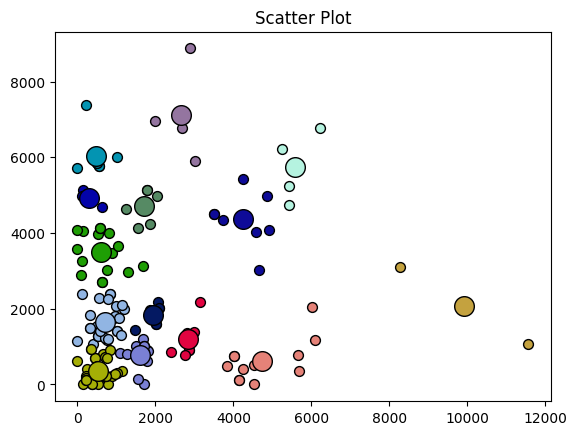

In [263]:
make_graph(K, cluster_index, centroids, combined_embeddings)